<a href="https://colab.research.google.com/github/macaluzate/Tarea_Cafe/blob/main/tarea3_caf%C3%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**CAFÉ**

![Proceso de Café](https://elsouvenir.com/wp-content/uploads/2020/06/Cafe%CC%81-y-cafe%CC%81-y-cafe%CC%81.-GIF-via-giphy.gif)

## 1. Introducción
**Objetivo:** Predecir el *puntaje de taza* de los lotes de café utilizando variables conocidas antes de la cata, evitando *data leakage*.  


## Importación de Librerias

In [1712]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime

### Lectura de los dataset
En esta etapa inicial, se realiza la carga y limpieza preliminar de los dos datasets proporcionados para el proyecto:

**CC FT 17**: Registro del control de calidad del café trillado.

**CC FT 18**: Registro del proceso de tostión.

Ambos datasets están almacenados en archivos Excel con múltiples hojas. Por lo tanto, se decidió concatenar las hojas relevantes en un solo DataFrame para cada archivo.

In [1713]:
# Rutas exactas de los archivos
file_17 = '/content/CC FT 17   Formato de Control de Calidad Café de Trillado (1).xlsx'
file_18 = '/content/CC FT 18  Formato de  Tostión (1).xlsx'

# Función para limpiar nombres de columna
def clean_columns(df):
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]  # quitar columnas sin nombre
    df.columns = df.columns.str.strip().str.upper()       # espacios y mayúsculas
    return df

# Cargar y limpiar los datos
# Normaliza todas las columnas a MAYÚSCULAS y sin espacios

df1 = pd.read_excel(file_17, sheet_name='CONTROL CALIDAD CAFE TRILLADO J', skiprows=5)
df2 = pd.read_excel(file_17, sheet_name='Sheet2', skiprows=5)
df17 = pd.concat([df1, df2], ignore_index=True)


df3 = pd.read_excel(file_18, sheet_name='TOSTIÓN JERICÓ L', skiprows=5)
df4 = pd.read_excel(file_18, sheet_name='TOSTIÓN JERICÓ', skiprows=5)
df18 = pd.concat([df3, df4], ignore_index=True)

df17 = clean_columns(df17)
df18 = clean_columns(df18)
df17.columns = df17.columns.str.strip().str.upper()
df18.columns = df18.columns.str.strip().str.upper()
df17 = df17.drop(index=[0,1])               # borra la fila vacía y la de 'N°'
df17 = df17.reset_index(drop=True)          # reindexa



In [1714]:
# Verifica los nombres exactos de las columnas en cada hoja
print("Columnas en df1:", df1.columns.tolist())
print("Columnas en df2:", df2.columns.tolist())

Columnas en df1: ['FECHA', 'LOTE  ', 'DENOMINACIÓN/     MARCA', 'CANTIDAD', '%H', 'Unnamed: 5', 'MALLAS', 'Unnamed: 7', 'VERIFICACIÓN FISICA CAFÉ TOSTADO ', 'NOTAS DE CATACIÓN', 'PUNTAJE', 'Unnamed: 11', 'LIBERACIÓN DE LOTE', 'RESPONSABLE ']
Columnas en df2: ['FECHA', 'LOTE  ', 'DENOMINACIÓN/     MARCA', 'CANTIDAD', '%H', 'Unnamed: 5', 'MALLAS', 'Unnamed: 7', 'VERIFICACIÓN FISICA CAFÉ TOSTADO ', 'NOTAS DE CATACIÓN', 'PUNTAJE', 'Unnamed: 11', 'LIBERACIÓN DE LOTE', 'RESPONSABLE ']


In [1715]:
print("Columnas en df1:", df3.columns.tolist())
print("Columnas en df2:", df4.columns.tolist())

Columnas en df1: ['Fecha ', 'Lote ', 'Origen', 'Variedad', 'Proceso', 'Beneficio ', 'Peso en Verde', 'Merma ', 'Peso en Tostado ', 'Perfil ', 'Temp. De inicio y final', 'Tiempo de tueste', 'Observaciones ', 'Tostador']
Columnas en df2: ['Fecha ', 'Lote ', 'Origen', 'Variedad', 'Proceso', 'Beneficio ', 'Peso en Verde', 'Merma ', 'Peso en Tostado ', 'Perfil ', 'Temp. De inicio y final', 'Tiempo de tueste', 'Observaciones ', 'Tostador']


In [1716]:
df18.columns.tolist()

['FECHA',
 'LOTE',
 'ORIGEN',
 'VARIEDAD',
 'PROCESO',
 'BENEFICIO',
 'PESO EN VERDE',
 'MERMA',
 'PESO EN TOSTADO',
 'PERFIL',
 'TEMP. DE INICIO Y FINAL',
 'TIEMPO DE TUESTE',
 'OBSERVACIONES',
 'TOSTADOR']

In [1717]:
df17.tail(10)

,FECHA,LOTE,DENOMINACIÓN/ MARCA,CANTIDAD,%H,MALLAS,VERIFICACIÓN FISICA CAFÉ TOSTADO,NOTAS DE CATACIÓN,PUNTAJE,LIBERACIÓN DE LOTE,RESPONSABLE
129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
135,Parámetros:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
136,% H≤11.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
137,Granulometria Café UGQ: Tolerancia del 5% por ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138,Verificación Fisica de Café Tostado: Máximo 5 ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Hay una información extra que no es relevante para el estudio y la estrctura de el dataset en si, por lo ue hay las removemos con esta linea de código.

In [1718]:
df17 = df17.drop(index=range(125, 139))  # excluye filas 125-136
df17 = df17.reset_index(drop=True)  # reindexa después de eliminar

In [1719]:
df17.tail(10)

,FECHA,LOTE,DENOMINACIÓN/ MARCA,CANTIDAD,%H,MALLAS,VERIFICACIÓN FISICA CAFÉ TOSTADO,NOTAS DE CATACIÓN,PUNTAJE,LIBERACIÓN DE LOTE,RESPONSABLE
115,2023-01-03 00:00:00,08-010323,Gesha Villabernarda,50.00,10.5,14,C,"Jazmin, mandarina, acidez jugosa, cuerpo sedos...",86,SI,AC
116,28-03-23,01-280323,Madre Laura,60.00,10.8,14,C,"Chocolate negro, toque frutal, cuerpo medio, a...",84,SI,AC
117,29-03-23,01-290323,Madre Laura,65.00,10.5,14,C,"Chocolate negro, toque frutal, cuerpo medio, a...",84,SI,AC
118,2023-10-04 00:00:00,01-100423,Madre Laura,120.00,10.8,14,C,"Chocolate negro, toque frutal, cuerpo medio, a...",84,SI,AC
119,24-04-23,01-240423,Madre Laura,101.45,10.5,14,C,"Chocolate negro, toque frutal, cuerpo medio, a...",84,SI,AC
120,2023-05-04 00:00:00,01-040523,Madre Laura,40.00,10.8,14,C,"Chocolate negro, toque frutal, cuerpo medio, a...",84,SI,AC
121,2023-06-15 00:00:00,01-150623,Madre Laura,10.00,10.5,14,C,"Chocolate negro, toque frutal, cuerpo medio, a...",84,SI,AC
122,2023-10-27 00:00:00,01-271023,Madre Laura,20.00,10.5,14,C,"Chocolate negro, toque frutal, cuerpo medio, a...",84,SI,AC
123,10-Ene-2024,01-100124,Madre Laura,20.00,10.4,14,c,"Chocolate negro, toque frutal, cuerpo medio, a...",84,SI,AC
124,02-Abril-2024,01-020424,Madre Laura,20.00,10.5,14,C,"Chocolate negro, toque frutal, cuerpo medio, a...",84,SI,AC


In [1720]:
df17['MALLAS'].isnull().sum()

np.int64(18)

In [1721]:
df17['CANTIDAD'].isnull().sum()

np.int64(19)

In [1722]:
df17.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   FECHA                             110 non-null    object 
 1   LOTE                              106 non-null    object 
 2   DENOMINACIÓN/     MARCA           106 non-null    object 
 3   CANTIDAD                          106 non-null    float64
 4   %H                                107 non-null    object 
 5   MALLAS                            107 non-null    object 
 6   VERIFICACIÓN FISICA CAFÉ TOSTADO  107 non-null    object 
 7   NOTAS DE CATACIÓN                 105 non-null    object 
 8   PUNTAJE                           105 non-null    object 
 9   LIBERACIÓN DE LOTE                106 non-null    object 
 10  RESPONSABLE                       105 non-null    object 
dtypes: float64(1), object(10)
memory usage: 10.9+ KB


Observando la información de arriba y examinando el dataset 17 se puede apreciar que hay columnas que deberian ser de tipo númerico denotadas como object. Comienzo entonces haciendo la conversión utilizando pandas por medio de pd.to_numeric

In [1723]:
df17['MALLAS'] = pd.to_numeric(df17['MALLAS'], errors='coerce')

# Convertir '%H' a numérico
df17['%H'] = pd.to_numeric(df17['%H'].astype(str).str.replace(',', '.'), errors='coerce')

df17['PUNTAJE'] = pd.to_numeric(df17['PUNTAJE'], errors='coerce')
df17 = df17.dropna(subset=['PUNTAJE']).reset_index(drop=True)

In [1724]:
print(df17[['%H', 'MALLAS']].info())
print(df17[['%H', 'MALLAS']].head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   %H      103 non-null    float64
 1   MALLAS  103 non-null    float64
dtypes: float64(2)
memory usage: 1.7 KB
None
     %H  MALLAS
0  10.9    14.0
1  10.2    14.0
2  10.7    14.0
3  10.5    14.0
4  10.7    14.0


  *DTYPE* a float64.

In [1725]:
df18.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 529 entries, 0 to 528
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   FECHA                    529 non-null    object 
 1   LOTE                     529 non-null    object 
 2   ORIGEN                   529 non-null    object 
 3   VARIEDAD                 529 non-null    object 
 4   PROCESO                  529 non-null    object 
 5   BENEFICIO                529 non-null    object 
 6   PESO EN VERDE            529 non-null    float64
 7   MERMA                    529 non-null    float64
 8   PESO EN TOSTADO          529 non-null    float64
 9   PERFIL                   529 non-null    object 
 10  TEMP. DE INICIO Y FINAL  529 non-null    object 
 11  TIEMPO DE TUESTE         529 non-null    object 
 12  OBSERVACIONES            19 non-null     object 
 13  TOSTADOR                 529 non-null    object 
dtypes: float64(3), object(11)


In [1726]:
df18.head(80)

,FECHA,LOTE,ORIGEN,VARIEDAD,PROCESO,BENEFICIO,PESO EN VERDE,MERMA,PESO EN TOSTADO,PERFIL,TEMP. DE INICIO Y FINAL,TIEMPO DE TUESTE,OBSERVACIONES,TOSTADOR
0,22-07-22,01-190722,Jerico,Dos mil,Tradicional,Lavado,9.00,15.000000,7.65,Filtrado,175°/191°,08:01:00,NaN,LFQ
1,25-07-22,01-190722,Jerico,Dos mil,Tradicional,Lavado,3.00,16.666667,2.50,Espressso,175°/195°,08:42:00,NaN,LFQ
2,25-07-22,01-190722,Jerico,Dos mil,Tradicional,Lavado,9.00,16.444444,7.52,Filtrado,175°/190°,07:58:00,NaN,LFQ
3,28-07-22,01-190722,Jerico,Dos mil,Tradicional,Lavado,11.70,16.324786,9.79,Filtrado,175°/191°,08:02:00,NaN,LFQ
4,28-07-22,09-190722,Ciudad Bolivar,Tabi,Natural,Natural,0.45,24.444444,0.34,Filtrado,150°/186°,08:10:00,NaN,LFQ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,2023-06-01 00:00:00,08-241122,Jerico,Gesha,Honey,Honey,2.80,15.000000,2.38,Filtrado,170°/189°,08:02:00,NaN,LFQ
76,2023-06-01 00:00:00,02-241122,Jerico,Dos mil,Natural,Natural,6.20,18.064516,5.08,Filtrado,170°/191°,08:10:00,NaN,LFQ
77,2023-06-01 00:00:00,05-241122,Jerico,Dos mil,Tradicional,Lavado,5.00,11.600000,4.42,Filtrado,170°/192°,08:05:00,NaN,LFQ
78,2023-06-01 00:00:00,01-291022,Jerico,Dos mil,Tradicional,Lavado,15.50,16.645161,12.92,Filtrado,170°/191°,08:04:00,NaN,LFQ


In [1727]:
df17.duplicated().sum()

np.int64(0)

In [1728]:
df18.duplicated().sum()

np.int64(1)

In [1729]:
# Mostrar todas las filas que están duplicadas en df18 (keep=False marca TODAS las copias)
duplicated_rows = df18[df18.duplicated(keep=False)]
print("Filas duplicadas en df18:\n", duplicated_rows)


Filas duplicadas en df18:
                    FECHA       LOTE    ORIGEN    VARIEDAD   PROCESO BENEFICIO  \
127  2023-01-03 00:00:00  11-010223  Herrera   Wush Wush   Natural   Natural    
130  2023-01-03 00:00:00  11-010223  Herrera   Wush Wush   Natural   Natural    

     PESO EN VERDE      MERMA  PESO EN TOSTADO    PERFIL  \
127            1.2  16.666667              1.0  Filtrado   
130            1.2  16.666667              1.0  Filtrado   

    TEMP. DE INICIO Y FINAL TIEMPO DE TUESTE OBSERVACIONES TOSTADOR  
127               175°/190°         06:52:00           NaN     LFQ   
130               175°/190°         06:52:00           NaN     LFQ   


### **Pequeña apreciación**

revisando el dataset 18 se ve un duplicado completo

Error de captura: alguien pudo haber pegado o subido dos veces la misma línea.

Múltiples mediciones con mismos parámetros: tal vez se tostó dos bolsas diferentes del mismo lote bajo condiciones idénticas y se registraron por separado.



In [1730]:
df18.head()

,FECHA,LOTE,ORIGEN,VARIEDAD,PROCESO,BENEFICIO,PESO EN VERDE,MERMA,PESO EN TOSTADO,PERFIL,TEMP. DE INICIO Y FINAL,TIEMPO DE TUESTE,OBSERVACIONES,TOSTADOR
0,22-07-22,01-190722,Jerico,Dos mil,Tradicional,Lavado,9.00,15.000000,7.65,Filtrado,175°/191°,08:01:00,NaN,LFQ
1,25-07-22,01-190722,Jerico,Dos mil,Tradicional,Lavado,3.00,16.666667,2.50,Espressso,175°/195°,08:42:00,NaN,LFQ
2,25-07-22,01-190722,Jerico,Dos mil,Tradicional,Lavado,9.00,16.444444,7.52,Filtrado,175°/190°,07:58:00,NaN,LFQ
3,28-07-22,01-190722,Jerico,Dos mil,Tradicional,Lavado,11.70,16.324786,9.79,Filtrado,175°/191°,08:02:00,NaN,LFQ
4,28-07-22,09-190722,Ciudad Bolivar,Tabi,Natural,Natural,0.45,24.444444,0.34,Filtrado,150°/186°,08:10:00,NaN,LFQ


In [1731]:
df17.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   FECHA                             103 non-null    object 
 1   LOTE                              103 non-null    object 
 2   DENOMINACIÓN/     MARCA           103 non-null    object 
 3   CANTIDAD                          103 non-null    float64
 4   %H                                103 non-null    float64
 5   MALLAS                            103 non-null    float64
 6   VERIFICACIÓN FISICA CAFÉ TOSTADO  103 non-null    object 
 7   NOTAS DE CATACIÓN                 103 non-null    object 
 8   PUNTAJE                           103 non-null    float64
 9   LIBERACIÓN DE LOTE                103 non-null    object 
 10  RESPONSABLE                       103 non-null    object 
dtypes: float64(4), object(7)
memory usage: 9.0+ KB


In [1732]:
print(df17.isnull().sum())

FECHA                               0
LOTE                                0
DENOMINACIÓN/     MARCA             0
CANTIDAD                            0
%H                                  0
MALLAS                              0
VERIFICACIÓN FISICA CAFÉ TOSTADO    0
NOTAS DE CATACIÓN                   0
PUNTAJE                             0
LIBERACIÓN DE LOTE                  0
RESPONSABLE                         0
dtype: int64


##Limpieza y Análisis Exploratorio

Comienzo viendo si hay datos mixtos en las columnas, ya que para hacer OneHot se necesita la únicidad.

In [1733]:
for col in df17.columns:
    tipos = set(df17[col].dropna().map(type))
    if len(tipos) > 1:
        print(f"⚠ {col}: mezcla de tipos → {tipos}")
    else:
        print(f"{col}: único tipo → {tipos}")


⚠ FECHA: mezcla de tipos → {<class 'datetime.datetime'>, <class 'str'>}
LOTE: único tipo → {<class 'str'>}
DENOMINACIÓN/     MARCA: único tipo → {<class 'str'>}
CANTIDAD: único tipo → {<class 'float'>}
%H: único tipo → {<class 'float'>}
MALLAS: único tipo → {<class 'float'>}
VERIFICACIÓN FISICA CAFÉ TOSTADO: único tipo → {<class 'str'>}
NOTAS DE CATACIÓN: único tipo → {<class 'str'>}
PUNTAJE: único tipo → {<class 'float'>}
LIBERACIÓN DE LOTE: único tipo → {<class 'str'>}
RESPONSABLE: único tipo → {<class 'str'>}


In [1734]:
for col in df18.columns:
    tipos = set(df18[col].dropna().map(type).unique())
    if len(tipos) > 1:
        print(f"⚠ {col}: tipos detectados → {tipos}")


⚠ FECHA: tipos detectados → {<class 'datetime.datetime'>, <class 'str'>}
⚠ TIEMPO DE TUESTE: tipos detectados → {<class 'datetime.time'>, <class 'str'>}


Por los resultados obtenidos noto que el dataset 17 solo tiene la columna FECHA con tipos mezclados.

Para el caso del dataset 18, Tomo la decisión de crear una nueva columna transformando los datos de la columna ***TIEMPO DE TUESTE*** a minutos, pues tengo la idea que esta variable será importante para predecir el puntaje del café.

In [1735]:
# Nombre exacto de la columna original
col = 'TIEMPO DE TUESTE'

# 1) Homogeneizar a string y parsear como timedelta
df18['TIEMPO_DELTA'] = pd.to_timedelta(df18[col].astype(str), errors='coerce')

# 2) Extraer minutos
df18['TIEMPO DE TUESTE EN MIN'] = df18['TIEMPO_DELTA'].dt.total_seconds() / 60

# 3) Eliminar columnas intermedias y la original
df18 = df18.drop(columns=[col, 'TIEMPO_DELTA'])

print(df18[['TIEMPO DE TUESTE EN MIN']].head())



   TIEMPO DE TUESTE EN MIN
0                    481.0
1                    522.0
2                    478.0
3                    482.0
4                    490.0


In [1736]:
#Viendo valores únicos de Origen
n_unique = df18['ORIGEN'].nunique()
print("Valores únicos en ORIGEN:", n_unique)
print(df18['ORIGEN'].value_counts())

Valores únicos en ORIGEN: 14
ORIGEN
Jerico             334
Jerico              32
Ciudad Bolivar      21
Herrra              18
Aipe                17
Herrera             17
Chaparral           17
Planadas            16
Salento             14
Acevedo             12
Quimbaya            10
Rovira               9
Rioblanco            8
San Antonio          4
Name: count, dtype: int64


Revisando el Excel, veo que hay varias filas con datos mal escritos, tendré que corregir y unificar.

**Lo haré despues de hacer el merge de los 2 dataset(17 y 18)**

In [1737]:
df18.head()

,FECHA,LOTE,ORIGEN,VARIEDAD,PROCESO,BENEFICIO,PESO EN VERDE,MERMA,PESO EN TOSTADO,PERFIL,TEMP. DE INICIO Y FINAL,OBSERVACIONES,TOSTADOR,TIEMPO DE TUESTE EN MIN
0,22-07-22,01-190722,Jerico,Dos mil,Tradicional,Lavado,9.00,15.000000,7.65,Filtrado,175°/191°,NaN,LFQ,481.0
1,25-07-22,01-190722,Jerico,Dos mil,Tradicional,Lavado,3.00,16.666667,2.50,Espressso,175°/195°,NaN,LFQ,522.0
2,25-07-22,01-190722,Jerico,Dos mil,Tradicional,Lavado,9.00,16.444444,7.52,Filtrado,175°/190°,NaN,LFQ,478.0
3,28-07-22,01-190722,Jerico,Dos mil,Tradicional,Lavado,11.70,16.324786,9.79,Filtrado,175°/191°,NaN,LFQ,482.0
4,28-07-22,09-190722,Ciudad Bolivar,Tabi,Natural,Natural,0.45,24.444444,0.34,Filtrado,150°/186°,NaN,LFQ,490.0


In [1738]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   FECHA                             103 non-null    object 
 1   LOTE                              103 non-null    object 
 2   DENOMINACIÓN/     MARCA           103 non-null    object 
 3   CANTIDAD                          103 non-null    float64
 4   %H                                103 non-null    float64
 5   MALLAS                            103 non-null    float64
 6   VERIFICACIÓN FISICA CAFÉ TOSTADO  103 non-null    object 
 7   NOTAS DE CATACIÓN                 103 non-null    object 
 8   PUNTAJE                           103 non-null    float64
 9   LIBERACIÓN DE LOTE                103 non-null    object 
 10  RESPONSABLE                       103 non-null    object 
 11  VARIEDAD_ESTANDAR                 103 non-null    object 
 12  PROCESO 

In [1739]:
df.head(200)

,FECHA,LOTE,DENOMINACIÓN/ MARCA,CANTIDAD,%H,MALLAS,VERIFICACIÓN FISICA CAFÉ TOSTADO,NOTAS DE CATACIÓN,PUNTAJE,LIBERACIÓN DE LOTE,RESPONSABLE,VARIEDAD_ESTANDAR,PROCESO,ORIGEN,TIEMPO_DE_TUESTE_MIN,TIEMPO_TUESTE_MEDIAN,BENEFICIO
0,19-07-22,01-190722,Madre Laura,765.00,10.9,14.0,C,"Chocolate negro, toque frutal, cuerpo medio, a...",84.0,SI,LFQ,Otros,NAN,NAN,NaN,492.0,NAN
1,19-7-22,09-190722,Tabi Natural,204.00,10.2,14.0,C,"Frutas maduras, nibs de cacao, acidez brillant...",85.0,SI,LFQ,Otros,NAN,NAN,NaN,492.0,NAN
2,19-07-22,10-190722,Don Mario,165.00,10.7,14.0,C,"Panela, durazno, miel, acidez brillante citric...",84.5,SI,LFQ,Dos mil,TRADICIONAL,JERICO,495.0,495.0,LAVADO
3,27-07-22,07-19-07-22,Don Felix,0.45,10.5,14.0,C,"Moras maduras, chocolate negro, acidez media c...",84.5,SI,LFQ,Dos mil,TRADICIONAL,JERICO,495.0,495.0,LAVADO
4,31-10-22,01-291022,Madre Laura,105.00,10.7,14.0,C,"Chocolate negro, toque frutal, cuerpo medio, a...",84.0,SI,LFQ,Otros,NAN,NAN,NaN,492.0,NAN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,2023-05-04 00:00:00,01-040523,Madre Laura,40.00,10.8,14.0,C,"Chocolate negro, toque frutal, cuerpo medio, a...",84.0,SI,AC,Otros,NAN,NAN,NaN,492.0,NAN
99,2023-06-15 00:00:00,01-150623,Madre Laura,10.00,10.5,14.0,C,"Chocolate negro, toque frutal, cuerpo medio, a...",84.0,SI,AC,Otros,NAN,NAN,NaN,492.0,NAN
100,2023-10-27 00:00:00,01-271023,Madre Laura,20.00,10.5,14.0,C,"Chocolate negro, toque frutal, cuerpo medio, a...",84.0,SI,AC,Otros,NAN,NAN,NaN,492.0,NAN
101,10-Ene-2024,01-100124,Madre Laura,20.00,10.4,14.0,C,"Chocolate negro, toque frutal, cuerpo medio, a...",84.0,SI,AC,Otros,NAN,NAN,NaN,492.0,NAN


## Matrices de Correlación y gráficos de los dataset

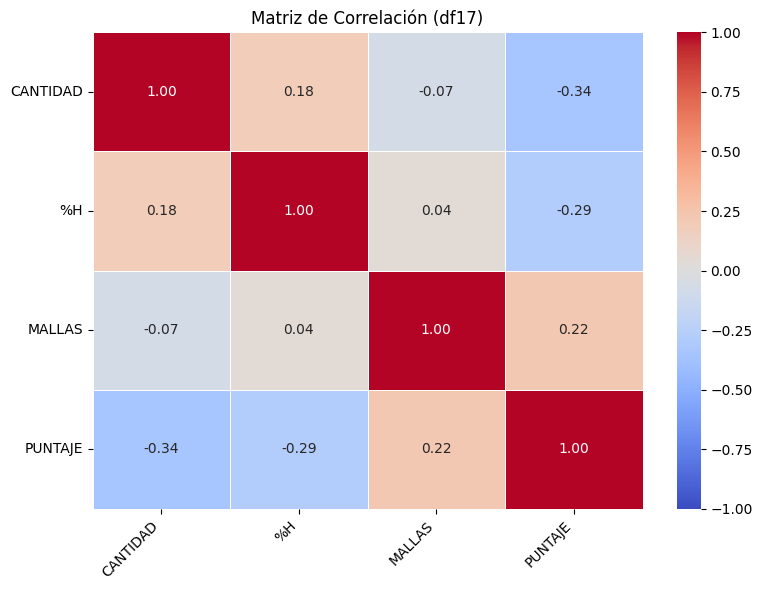

In [1740]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Selecciona las columnas numéricas de df17 (excepto PUNTAJE si está incluida)
numeric_cols_17 = df17.select_dtypes(include=['int64','float64']).columns.tolist()
if 'PUNTAJE' in numeric_cols_17:
    numeric_cols_17.remove('PUNTAJE')

# 2) Define el listado completo incluyendo PUNTAJE
cols17 = numeric_cols_17 + ['PUNTAJE']

# 3) Calcula la matriz de correlación
corr17 = df17[cols17].corr()

# 4) Grafica el heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr17,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    linewidths=0.5
)
plt.title('Matriz de Correlación (df17)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### VERIFICACIÓN DE OUTLIERS EN LOS DATOS

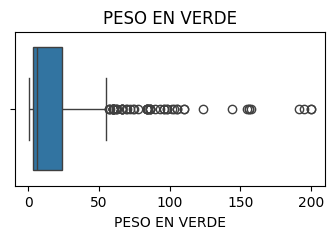

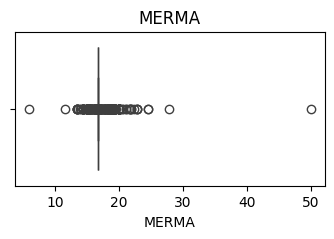

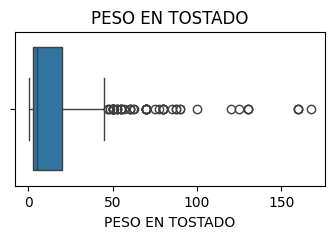

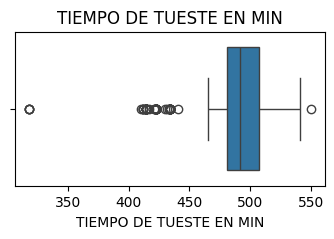

In [1741]:
import seaborn as sns
import matplotlib.pyplot as plt

num_cols = df18.select_dtypes(include=['int64','float64']).columns
for col in num_cols:
    plt.figure(figsize=(4,2))
    sns.boxplot(x=df18[col])
    plt.title(col)
    plt.show()


Los puntos aislados a la derecha indican valores extremadamente altos, lejos de la mayoría de los datos. Esto sugiere registros potencialmente erróneos o eventos excepcionales en la medición del peso del café tostado.

Distribución sesgada hacia la derecha:

La caja está situada hacia la izquierda, lo que indica que la mayoría de los valores se concentra en valores más bajos (por debajo de 50 aproximadamente). La cola hacia la derecha es larga, indicando que hay muestras puntuales con pesos considerablemente mayores que la media.

Mediana y rango intercuartil (IQR):

La línea central (mediana) está cerca del extremo inferior del rango total de los datos, reforzando el sesgo hacia pesos bajos.

El rango intercuartílico (la caja azul) es relativamente estrecho, lo cual indica que la mayoría de los datos están bastante concentrados alrededor de la mediana.

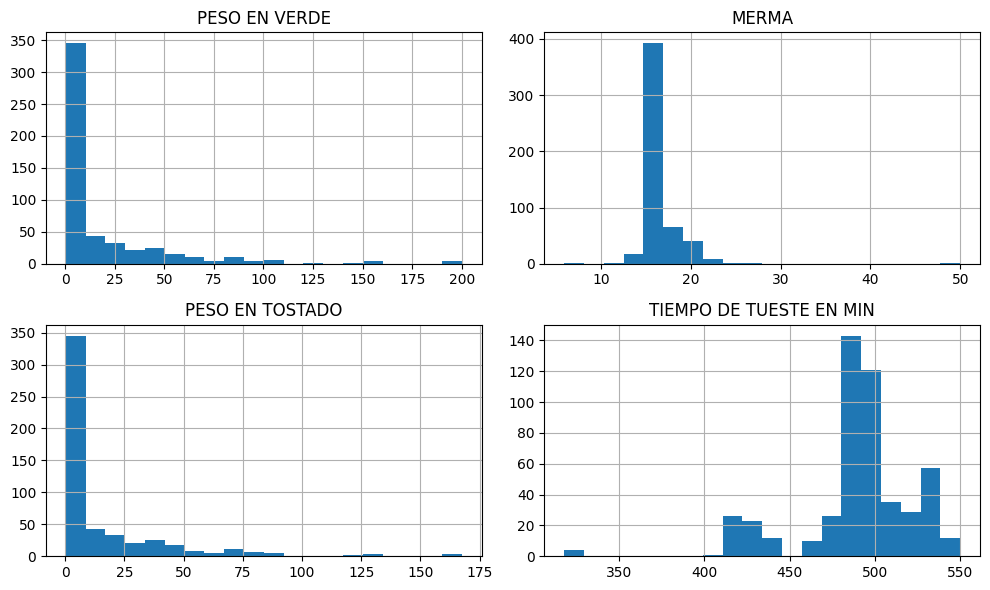

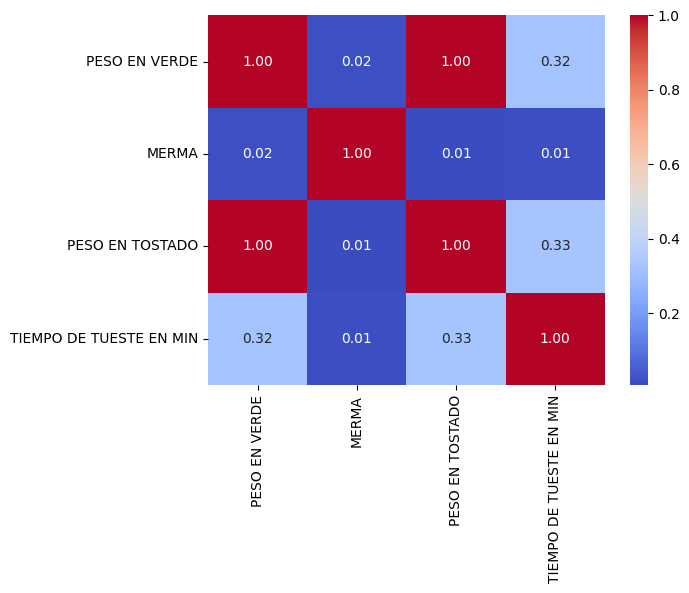

In [1742]:
# Histograma de cada numérica
df18[num_cols].hist(bins=20, figsize=(10,6))
plt.tight_layout()
plt.show()

# Matriz de correlación
corr = df18[num_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()


## Unificación del *dataset*

Estoy en un proceso de unificación y limpieza del dataset. Entonces lo que quiero escribir es lo siguiente. Estoy en un proceso de unificación y limpieza del dataset. Entonces lo que quiero escribir es lo siguiente. Viendo las columnas de los dos datasets, vemos que hay una que se comparte, que es la columna lote. Pero como los datasets 17 y 18 tienen un número de columnas dispares, entonces no es viable directamente hacer el merge. La decisión que tomé es la siguiente:

Observando los datasets, me doy cuenta que la columna de **denominación/ marca** del dataset 17 puede ser interesante porque eso va a desprender en... en qué columnas del dataset 18 tienen relación con ésta. Por ejemplo, la columna variedad dice, Dos Mil, Tabi, dice Colombia, dice Geisha, y esos son nombres que están en la denominación o en la marca. Por lo tanto, a partir de ahí voy a hacer mi análisis para poder entonces unificar esos dos datasets.



In [1743]:
df['RESPONSABLE'].value_counts()

,count
RESPONSABLE,
LFQ,75
AC,28


In [1744]:
df['RESPONSABLE'] = df['RESPONSABLE'].str.strip()
df['RESPONSABLE'].value_counts()

,count
RESPONSABLE,
LFQ,75
AC,28


Lo siguiente es identificar un mapeo de variedades entre la columna **VARIEDAD** y la columna **DENOMINACIÓN / MARCA**, para crear un nuevo dataset llamado **DF**. Con **DF** se realizará entonces el procesamiento y el entrenamiento.


In [1745]:
# Primero definimos el diccionario base
mapeo_variedades = {
    # Mapeos específicos
    'Tabi Natural': 'Tabi',
    'Don Mario': 'Dos mil',
    'Monteverde - Wush Wush': 'Wush Wush',
    'Don Felix': 'Dos mil',
    'Doña Dolly': 'Dos mil',
    'Madre Laura Natural': 'Dos mil',
    'Madre Laura': 'Dos mil',

    # Todo lo Gesha
    'Gesha Villabernarda': 'Gesha',
    'Gesha Villa - Natural': 'Gesha',
    'Gesha Blue - Monteverde': 'Gesha',

    # Todo lo Don -> Dos mil
    **{nombre: 'Dos mil' for nombre in df17['DENOMINACIÓN/     MARCA'].unique()
       if isinstance(nombre, str) and nombre.startswith('Don')},

    # Bourbon a Bourbon Rojo
    **{nombre: 'Bourbon Rojo' for nombre in df17['DENOMINACIÓN/     MARCA'].unique()
       if isinstance(nombre, str) and 'Bourbon' in nombre},

    # Caso especial
    'El Ocaso - Caturron': 'Caturra'
}

# Luego añadimos el caso "Otros" por separado
otros_mapes = {
    nombre: 'Otros' for nombre in df17['DENOMINACIÓN/     MARCA'].unique()
    if isinstance(nombre, str) and nombre not in mapeo_variedades
}

# Combinamos ambos diccionarios
mapeo_variedades.update(otros_mapes)

Esa **VARIEDAD** en el nuevo dataset será denotada como **variedad_bajo_estandar**. Posteriormente unificaré (normalizaré) las columnas de **proceso**.


In [1746]:
df17['VARIEDAD_ESTANDAR'] = df17['DENOMINACIÓN/     MARCA'].map(mapeo_variedades)

In [1747]:
# Verifica que la columna existe exactamente así
print(df17.columns.tolist())

# Muestra los mapeos resultantes
print(mapeo_variedades)

['FECHA', 'LOTE', 'DENOMINACIÓN/     MARCA', 'CANTIDAD', '%H', 'MALLAS', 'VERIFICACIÓN FISICA CAFÉ TOSTADO', 'NOTAS DE CATACIÓN', 'PUNTAJE', 'LIBERACIÓN DE LOTE', 'RESPONSABLE', 'VARIEDAD_ESTANDAR']
{'Tabi Natural': 'Tabi', 'Don Mario': 'Dos mil', 'Monteverde - Wush Wush': 'Wush Wush', 'Don Felix': 'Dos mil', 'Doña Dolly': 'Dos mil', 'Madre Laura Natural': 'Dos mil', 'Madre Laura': 'Dos mil', 'Gesha Villabernarda': 'Gesha', 'Gesha Villa - Natural': 'Gesha', 'Gesha Blue - Monteverde': 'Gesha', 'Don Mario ': 'Dos mil', 'Don Felix ': 'Dos mil', 'Don Victor - Marago ': 'Dos mil', 'Don Rafael ': 'Dos mil', 'Don Johan': 'Dos mil', 'Don Victor - Red Bourbon': 'Bourbon Rojo', 'Don Victor ': 'Dos mil', 'El Ocaso - Pink Bourbon': 'Bourbon Rojo', 'El Cedrela - Pink Bourbon': 'Bourbon Rojo', 'Bourbon Sidra - Las Flores ': 'Bourbon Rojo', 'El Ocaso - Caturron': 'Caturra', 'Madre Laura ': 'Otros', 'Tabi Natural ': 'Otros', 'Madre Laura Descafeinado': 'Otros', 'Doña Rosalba ': 'Otros', 'Doña Liceth '

In [1748]:
# 1. Crear una COPIA de df17 para no modificarlo
df = df17.copy()

# 2. Aplicar el mapeo al nuevo DataFrame 'df'
df['VARIEDAD_ESTANDAR'] = df['DENOMINACIÓN/     MARCA'].map(mapeo_variedades)

# 3. Manejar valores no mapeados (opcional)
df['VARIEDAD_ESTANDAR'] = df['VARIEDAD_ESTANDAR'].fillna('Otros')  # O cualquier valor por defecto

In [1749]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   FECHA                             103 non-null    object 
 1   LOTE                              103 non-null    object 
 2   DENOMINACIÓN/     MARCA           103 non-null    object 
 3   CANTIDAD                          103 non-null    float64
 4   %H                                103 non-null    float64
 5   MALLAS                            103 non-null    float64
 6   VERIFICACIÓN FISICA CAFÉ TOSTADO  103 non-null    object 
 7   NOTAS DE CATACIÓN                 103 non-null    object 
 8   PUNTAJE                           103 non-null    float64
 9   LIBERACIÓN DE LOTE                103 non-null    object 
 10  RESPONSABLE                       103 non-null    object 
 11  VARIEDAD_ESTANDAR                 103 non-null    object 
dtypes: float

In [1750]:
df['VARIEDAD_ESTANDAR'].unique()


array(['Otros', 'Dos mil', 'Gesha', 'Wush Wush', 'Bourbon Rojo'],
      dtype=object)

In [1751]:
otros_df = df[df['VARIEDAD_ESTANDAR'] == 'Otros']
print(otros_df)

                   FECHA        LOTE   DENOMINACIÓN/     MARCA  CANTIDAD  \
0               19-07-22   01-190722              Madre Laura     765.00   
1                19-7-22   09-190722             Tabi Natural     204.00   
4               31-10-22   01-291022              Madre Laura     105.00   
5    2022-02-11 00:00:00   01-291022              Madre Laura     105.00   
6    2022-11-11 00:00:00   01-101122              Madre Laura     210.00   
10              30-12-22   01-291222              Madre Laura      70.00   
11              17-01-23   01-130123              Madre Laura     585.00   
12   2023-08-02 00:00:00   03-010223  Madre Laura Descafeinado    210.00   
13   2023-08-02 00:00:00   01-010223              Madre Laura     140.00   
21   2023-07-03 00:00:00   01-070323              Madre Laura     716.00   
22               14-4-23   09-120423             Tabi Natural      70.00   
24               20-4-23   01-200423              Madre Laura     691.00   
25          

In [1752]:
# Eliminar espacios en la columna 'DENOMINACIÓN/MARCA'
df['DENOMINACIÓN/     MARCA'] = df17['DENOMINACIÓN/     MARCA'].str.strip()

# Verificar resultados
print(df['DENOMINACIÓN/     MARCA'].unique())

['Madre Laura' 'Tabi Natural' 'Don Mario' 'Don Felix'
 'Gesha Villabernarda' 'Madre Laura Natural' 'Doña Dolly'
 'Madre Laura Descafeinado' 'Monteverde - Wush Wush'
 'El Ocaso - Pink Bourbon' 'El Cedrela - Pink Bourbon'
 'Don Victor - Marago' 'Don Rafael' 'Doña Rosalba' 'Doña Liceth'
 'Madre Laura Lavado' 'Familia Bedoya Castaño' 'Don Johan'
 'Gesha Blue - Monteverde' 'Bourbon Sidra - Las Flores'
 'Don Victor - Red Bourbon' 'El Ocaso - Caturron' 'Esteban Robledo'
 'Don Victor']


In [1753]:
df18['VARIEDAD'] = df18['VARIEDAD'].str.strip()

In [1754]:
df18.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 529 entries, 0 to 528
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   FECHA                    529 non-null    object 
 1   LOTE                     529 non-null    object 
 2   ORIGEN                   529 non-null    object 
 3   VARIEDAD                 529 non-null    object 
 4   PROCESO                  529 non-null    object 
 5   BENEFICIO                529 non-null    object 
 6   PESO EN VERDE            529 non-null    float64
 7   MERMA                    529 non-null    float64
 8   PESO EN TOSTADO          529 non-null    float64
 9   PERFIL                   529 non-null    object 
 10  TEMP. DE INICIO Y FINAL  529 non-null    object 
 11  OBSERVACIONES            19 non-null     object 
 12  TOSTADOR                 529 non-null    object 
 13  TIEMPO DE TUESTE EN MIN  499 non-null    float64
dtypes: float64(4), object(10)


In [1755]:
df18['VARIEDAD'].value_counts()

,count
VARIEDAD,
Dos mil,284
Gesha,57
Colombia,32
Pink Bourbon,30
Wush Wush,27
Tabi,21
Maragogipe,17
Red Bourbon,15
Caturra,13


In [1756]:
df18['VARIEDAD'].unique()

array(['Dos mil', 'Tabi', 'Caturra', 'Gesha', 'Colombia', 'Wush Wush',
       'Pink Bourbon', 'Maragogipe', 'Castillo', 'Bourbon Rojo',
       'Bourbon Sidra', 'Red Bourbon', 'Caturron'], dtype=object)

In [1757]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   FECHA                             103 non-null    object 
 1   LOTE                              103 non-null    object 
 2   DENOMINACIÓN/     MARCA           103 non-null    object 
 3   CANTIDAD                          103 non-null    float64
 4   %H                                103 non-null    float64
 5   MALLAS                            103 non-null    float64
 6   VERIFICACIÓN FISICA CAFÉ TOSTADO  103 non-null    object 
 7   NOTAS DE CATACIÓN                 103 non-null    object 
 8   PUNTAJE                           103 non-null    float64
 9   LIBERACIÓN DE LOTE                103 non-null    object 
 10  RESPONSABLE                       103 non-null    object 
 11  VARIEDAD_ESTANDAR                 103 non-null    object 
dtypes: float

In [1758]:
df18['PROCESO'].unique()

array(['Tradicional', 'Natural ', 'Honey ', 'Tradicional ', 'Lavado '],
      dtype=object)

In [1759]:
# Extraer pares únicos de VARIEDAD y PROCESO de df18
proceso_por_variedad = (
    df18.drop_duplicates('VARIEDAD')[['VARIEDAD', 'PROCESO']]
    .set_index('VARIEDAD')['PROCESO']
    .to_dict()
)

# Verificar el diccionario
print("Relación VARIEDAD → PROCESO:", proceso_por_variedad)

Relación VARIEDAD → PROCESO: {'Dos mil': 'Tradicional', 'Tabi': 'Natural ', 'Caturra': 'Tradicional', 'Gesha': 'Honey ', 'Colombia': 'Tradicional ', 'Wush Wush': 'Natural ', 'Pink Bourbon': 'Honey ', 'Maragogipe': 'Lavado ', 'Castillo': 'Tradicional', 'Bourbon Rojo': 'Honey ', 'Bourbon Sidra': 'Lavado ', 'Red Bourbon': 'Honey ', 'Caturron': 'Natural '}


In [1760]:
df['PROCESO'] = df['VARIEDAD_ESTANDAR'].map(proceso_por_variedad)

In [1761]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   FECHA                             103 non-null    object 
 1   LOTE                              103 non-null    object 
 2   DENOMINACIÓN/     MARCA           103 non-null    object 
 3   CANTIDAD                          103 non-null    float64
 4   %H                                103 non-null    float64
 5   MALLAS                            103 non-null    float64
 6   VERIFICACIÓN FISICA CAFÉ TOSTADO  103 non-null    object 
 7   NOTAS DE CATACIÓN                 103 non-null    object 
 8   PUNTAJE                           103 non-null    float64
 9   LIBERACIÓN DE LOTE                103 non-null    object 
 10  RESPONSABLE                       103 non-null    object 
 11  VARIEDAD_ESTANDAR                 103 non-null    object 
 12  PROCESO 

In [1762]:
df.head(20)

,FECHA,LOTE,DENOMINACIÓN/ MARCA,CANTIDAD,%H,MALLAS,VERIFICACIÓN FISICA CAFÉ TOSTADO,NOTAS DE CATACIÓN,PUNTAJE,LIBERACIÓN DE LOTE,RESPONSABLE,VARIEDAD_ESTANDAR,PROCESO
0,19-07-22,01-190722,Madre Laura,765.00,10.9,14.0,C,"Chocolate negro, toque frutal, cuerpo medio, a...",84.0,Si,LFQ,Otros,NaN
1,19-7-22,09-190722,Tabi Natural,204.00,10.2,14.0,C,"Frutas maduras, nibs de cacao, acidez brillant...",85.0,Si,LFQ,Otros,NaN
2,19-07-22,10-190722,Don Mario,165.00,10.7,14.0,C,"Panela, durazno, miel, acidez brillante citric...",84.5,Si,LFQ,Dos mil,Tradicional
3,27-07-22,07-19-07-22,Don Felix,0.45,10.5,14.0,C,"Moras maduras, chocolate negro, acidez media c...",84.5,Si,LFQ,Dos mil,Tradicional
4,31-10-22,01-291022,Madre Laura,105.00,10.7,14.0,C,"Chocolate negro, toque frutal, cuerpo medio, a...",84.0,Si,LFQ,Otros,NaN
5,2022-02-11 00:00:00,01-291022,Madre Laura,105.00,10.7,14.0,C,"Chocolate negro, toque frutal, cuerpo medio, a...",84.0,Si,LFQ,Otros,NaN
6,2022-11-11 00:00:00,01-101122,Madre Laura,210.00,10.7,14.0,C,"Chocolate negro, toque frutal, cuerpo medio, a...",84.0,Si,LFQ,Otros,NaN
7,2022-04-12 00:00:00,08-241122,Gesha Villabernarda,12.00,10.3,14.0,C,"Jazmin, mandarina, acidez jugosa, cuerpo sedos...",86.0,Si,LFQ,Gesha,Honey
8,2022-04-12 00:00:00,02-241122,Madre Laura Natural,19.40,10.5,14.0,C,"Cacao, frutos rojos, cuerpo cremoso, acidez br...",85.0,Si,LFQ,Dos mil,Tradicional
9,2022-04-12 00:00:00,05-241122,Doña Dolly,35.00,10.8,14.0,C,"Panela, fresa, acidez brillante, cuerpo cremos...",85.0,Si,LFQ,Dos mil,Tradicional


También unificaré las columnas de **origen** y **beneficio**.


In [1763]:
df['ORIGEN'] = df['VARIEDAD_ESTANDAR'].map(origen_por_variedad)

In [1764]:
# 1) Asegúrate de tener todo en mayúsculas y sin espacios extra
df['ORIGEN'] = (
    df['ORIGEN']
      .astype(str)
      .str.strip()
      .str.upper()
)

# 2) Mapear las variantes “HERRRA” y “HERRERA” a una sola
df['ORIGEN'] = df['ORIGEN'].replace({
    'HERRRA':  'HERRERA',
    'HERRERA': 'HERRERA'
})

# 3) Verifica que ahora sólo quede “HERRERA”
print(df['ORIGEN'].value_counts())

# 4) (Opcional) Lista única de ORIGEN para confirmar limpieza
print("Orígenes únicos tras corrección:", df['ORIGEN'].unique())
print("Orígenes únicos tras corrección:", df['ORIGEN'].nunique())

ORIGEN
NAN         58
JERICO      36
QUIMBAYA     5
HERRERA      4
Name: count, dtype: int64
Orígenes únicos tras corrección: ['NAN' 'JERICO' 'HERRERA' 'QUIMBAYA']
Orígenes únicos tras corrección: 4


In [1765]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 14 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   FECHA                             103 non-null    object 
 1   LOTE                              103 non-null    object 
 2   DENOMINACIÓN/     MARCA           103 non-null    object 
 3   CANTIDAD                          103 non-null    float64
 4   %H                                103 non-null    float64
 5   MALLAS                            103 non-null    float64
 6   VERIFICACIÓN FISICA CAFÉ TOSTADO  103 non-null    object 
 7   NOTAS DE CATACIÓN                 103 non-null    object 
 8   PUNTAJE                           103 non-null    float64
 9   LIBERACIÓN DE LOTE                103 non-null    object 
 10  RESPONSABLE                       103 non-null    object 
 11  VARIEDAD_ESTANDAR                 103 non-null    object 
 12  PROCESO 

In [1766]:
df['TIEMPO_DE_TUESTE_MIN'] = df['PROCESO'].map(tiempo_por_proceso)

He calculado el **tiempo de tueste en minutos** del *dataset* 18. Ahora voy a crear una columna llamada **TIEMPO_TUESTE_MEDIAN** en la que asignaré la **mediana** de esos tiempos.


In [1767]:
# 1. Calcular la mediana del tiempo por PROCESO en df18
tiempo_por_proceso = (
    df18.groupby('PROCESO')['TIEMPO DE TUESTE EN MIN']
    .median()
    .to_dict()
)


df['TIEMPO_TUESTE_MEDIAN'] = df['PROCESO'].map(tiempo_por_proceso)

# 3. Rellenar NaN con la mediana global (si hay procesos sin datos)
tiempo_global = df18['TIEMPO DE TUESTE EN MIN'].median()
df['TIEMPO_TUESTE_MEDIAN'] = df['TIEMPO_TUESTE_MEDIAN'].fillna(tiempo_global)

In [1768]:
# Extraer pares únicos de PROCESO y BENEFICIO de df18 (si existen)
beneficio_por_proceso = (
    df18.drop_duplicates('PROCESO')[['PROCESO', 'BENEFICIO']]
    .set_index('PROCESO')['BENEFICIO']
    .to_dict()
)

# Mapear al DataFrame principal
df['BENEFICIO'] = df['PROCESO'].map(beneficio_por_proceso)

Matriz de correlación:


,CANTIDAD,%H,MALLAS,PUNTAJE,TIEMPO_DE_TUESTE_MIN,TIEMPO_TUESTE_MEDIAN
CANTIDAD,1.000000,0.182458,-0.074534,-0.344391,0.378373,0.025207
%H,0.182458,1.000000,0.042370,-0.287196,0.536853,0.341246
MALLAS,-0.074534,0.042370,1.000000,0.220804,0.192077,0.191655
PUNTAJE,-0.344391,-0.287196,0.220804,1.000000,-0.641882,-0.351061
TIEMPO_DE_TUESTE_MIN,0.378373,0.536853,0.192077,-0.641882,1.000000,1.000000
TIEMPO_TUESTE_MEDIAN,0.025207,0.341246,0.191655,-0.351061,1.000000,1.000000


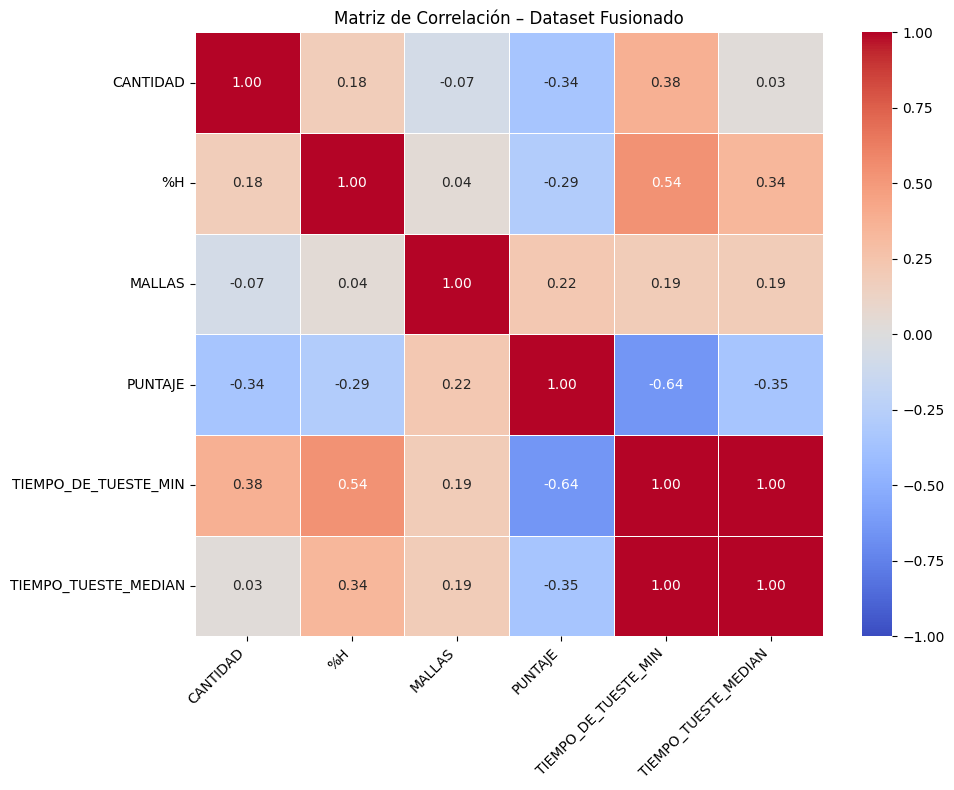

In [1769]:


# 1) Selecciona todas las columnas numéricas del DataFrame fusionado
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# 2) Calcula la matriz de correlación
corr_matrix = df[num_cols].corr()

# 3) Muestra la matriz en texto
print("Matriz de correlación:")
display(corr_matrix)

# 4) Dibuja un heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1, vmax=1,
    linewidths=0.5
)
plt.title("Matriz de Correlación – Dataset Fusionado")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [1770]:
print(df['MALLAS'].unique())
print(df['MALLAS'].isnull().sum())


[14. 16. 15.]
0


LA Columna Mallas tiene un único valor, la correlacion y la varianza nula seran insuficientes.

In [1771]:
df.head()

,FECHA,LOTE,DENOMINACIÓN/ MARCA,CANTIDAD,%H,MALLAS,VERIFICACIÓN FISICA CAFÉ TOSTADO,NOTAS DE CATACIÓN,PUNTAJE,LIBERACIÓN DE LOTE,RESPONSABLE,VARIEDAD_ESTANDAR,PROCESO,ORIGEN,TIEMPO_DE_TUESTE_MIN,TIEMPO_TUESTE_MEDIAN,BENEFICIO
0,19-07-22,01-190722,Madre Laura,765.00,10.9,14.0,C,"Chocolate negro, toque frutal, cuerpo medio, a...",84.0,Si,LFQ,Otros,NaN,NAN,NaN,492.0,NaN
1,19-7-22,09-190722,Tabi Natural,204.00,10.2,14.0,C,"Frutas maduras, nibs de cacao, acidez brillant...",85.0,Si,LFQ,Otros,NaN,NAN,NaN,492.0,NaN
2,19-07-22,10-190722,Don Mario,165.00,10.7,14.0,C,"Panela, durazno, miel, acidez brillante citric...",84.5,Si,LFQ,Dos mil,Tradicional,JERICO,495.0,495.0,Lavado
3,27-07-22,07-19-07-22,Don Felix,0.45,10.5,14.0,C,"Moras maduras, chocolate negro, acidez media c...",84.5,Si,LFQ,Dos mil,Tradicional,JERICO,495.0,495.0,Lavado
4,31-10-22,01-291022,Madre Laura,105.00,10.7,14.0,C,"Chocolate negro, toque frutal, cuerpo medio, a...",84.0,Si,LFQ,Otros,NaN,NAN,NaN,492.0,NaN


In [1772]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   FECHA                             103 non-null    object 
 1   LOTE                              103 non-null    object 
 2   DENOMINACIÓN/     MARCA           103 non-null    object 
 3   CANTIDAD                          103 non-null    float64
 4   %H                                103 non-null    float64
 5   MALLAS                            103 non-null    float64
 6   VERIFICACIÓN FISICA CAFÉ TOSTADO  103 non-null    object 
 7   NOTAS DE CATACIÓN                 103 non-null    object 
 8   PUNTAJE                           103 non-null    float64
 9   LIBERACIÓN DE LOTE                103 non-null    object 
 10  RESPONSABLE                       103 non-null    object 
 11  VARIEDAD_ESTANDAR                 103 non-null    object 
 12  PROCESO 

##  Revisión de columnas categóricas y valores únicos

Utilizando la siguiente línea de código:

se puede realizar una inspección inicial de las columnas categóricas del dataset, permitiendo visualizar información importante como:

Número de valores únicos por columna.

El valor más frecuente y su frecuencia.

In [1773]:
df.describe(include="object")

,FECHA,LOTE,DENOMINACIÓN/ MARCA,VERIFICACIÓN FISICA CAFÉ TOSTADO,NOTAS DE CATACIÓN,LIBERACIÓN DE LOTE,RESPONSABLE,VARIEDAD_ESTANDAR,PROCESO,ORIGEN,BENEFICIO
count,103,103,103,103,103,103,103,103,45,103,45
unique,72,99,24,2,27,4,3,5,3,4,3
top,2023-08-02 00:00:00,01-291022,Madre Laura,C,"Chocolate negro, toque frutal, cuerpo medio, a...",Si,LFQ,Otros,Tradicional,NAN,Lavado
freq,7,3,44,102,46,45,48,58,25,58,25


Revisando el Dataset me doy cuenta que la columna de Procesos y Beneficio comparten nombre en algunas filas. voy a hacer la limpieza de esas dos columnas

In [1774]:
df['LOTE'].isnull().sum()

np.int64(0)

/tmp/ipython-input-1775-3772915723.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


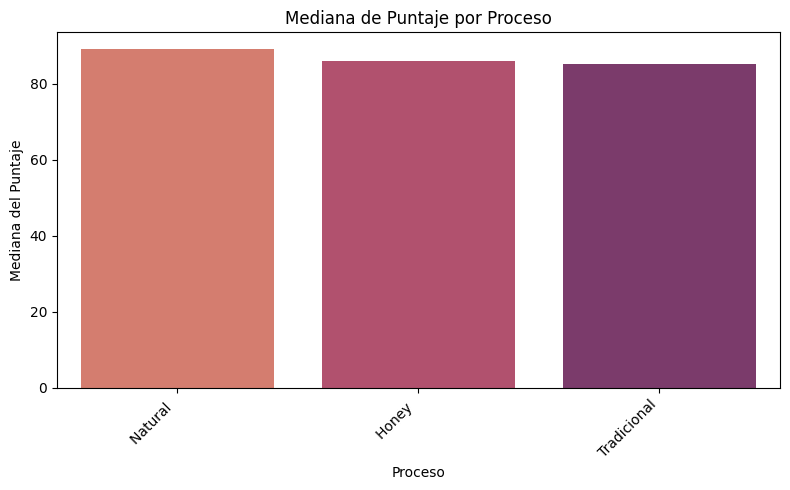

In [1775]:
# 1) Agrupa por PROCESO y calcula la mediana de PUNTAJE
df_proc = (
    df.groupby('PROCESO')['PUNTAJE']
      .median()
      .reset_index()
      .sort_values('PUNTAJE', ascending=False)
)

# 2) Dibuja el barplot
plt.figure(figsize=(8,5))
sns.barplot(
    x='PROCESO',
    y='PUNTAJE',
    data=df_proc,
    palette='flare'
)
plt.title('Mediana de Puntaje por Proceso')
plt.xlabel('Proceso')
plt.ylabel('Mediana del Puntaje')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

El gráfico anterior presenta la mediana del puntaje obtenido por cada tipo de proceso en el dataset. Esto nos permite evaluar si hay diferencias significativas en la calidad del café según la técnica utilizada.

Hay un pequeño error en la categoria tradicional, hay una con espacio y otra sin él.

/tmp/ipython-input-1776-735699057.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


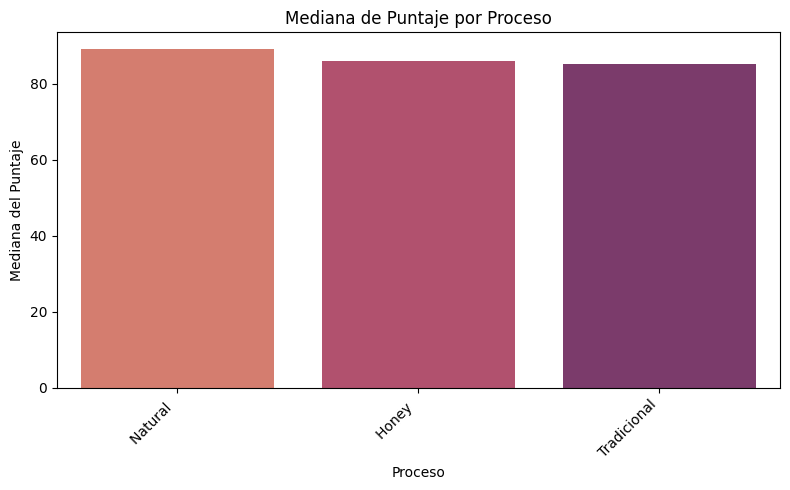

In [1776]:
#LIMPIEZA DE PROCESOS

# Agrupa por PROCESO y calcula la mediana de PUNTAJE
df_proc = (
    df.groupby('PROCESO')['PUNTAJE']
      .median()
      .reset_index()
      .sort_values('PUNTAJE', ascending=False)
)

# 2) Dibuja el barplot
plt.figure(figsize=(8,5))
sns.barplot(
    x='PROCESO',
    y='PUNTAJE',
    data=df_proc,
    palette='flare'
)
plt.title('Mediana de Puntaje por Proceso')
plt.xlabel('Proceso')
plt.ylabel('Mediana del Puntaje')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [1777]:
df['PROCESO'].unique()

array([nan, 'Tradicional', 'Honey ', 'Natural '], dtype=object)

In [1778]:
 #Aplica la limpieza con regex y solo muestra el resultado

# 1) Normaliza las columnas en una sola pasada
df['PROCESO'] = (
    df['PROCESO']
      .astype(str)
      .str.strip()                                # quita espacios al inicio/fin
      .str.replace(r'\s+', ' ', regex=True)       # colapsa múltiples espacios
      .str.upper()                                # pasa todo a mayúsculas
)



# 2) Imprime las primeras filas para ver cómo quedó


# 3) (Opcional) Lista todas las categorías únicas limpias
print("\nProcesos únicos tras limpieza:")
print(df['PROCESO'].unique())





Procesos únicos tras limpieza:
['NAN' 'TRADICIONAL' 'HONEY' 'NATURAL']


In [1779]:
# Normalización previa: convierte todo a cadena, quita espacios de los extremos, colapsa múltiples
df['RESPONSABLE'] = (
    df['RESPONSABLE']
      .astype(str)
      .str.strip()                              # quita espacios al inicio/fin
      .str.replace(r'\s+', ' ', regex=True)     # colapsa espacios múltiples
      .str.replace(' ', '')                     # **¡ELIMINA todos los espacios!**
      .str.upper()                              # uniformiza a mayúsculas
)

# Ahora cuenta de nuevo
vc = df['RESPONSABLE'].value_counts()
print(vc)

# Y tus RESPONSABLEes principales
main_RESPONSABLEes = vc[vc > 10].index.tolist()
print("RESPONSABLEes principales:", main_RESPONSABLEes)


RESPONSABLE
LFQ    75
AC     28
Name: count, dtype: int64
RESPONSABLEes principales: ['LFQ', 'AC']


RESPONSABLEes principales: ['LFQ', 'AC']


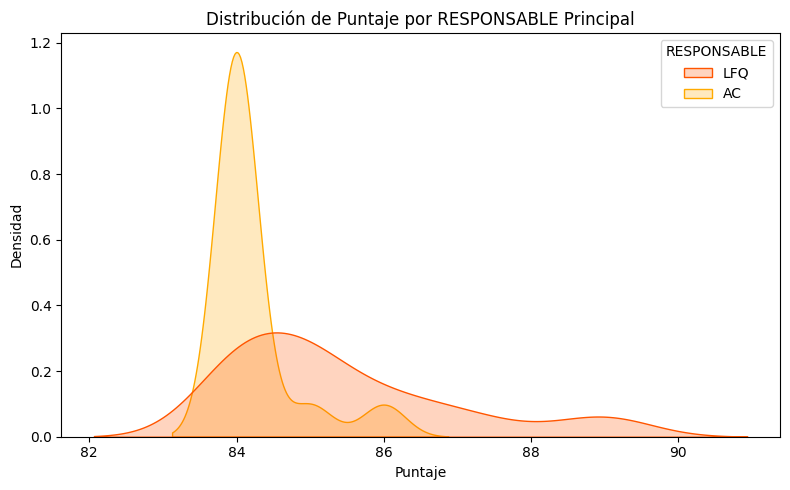

In [1780]:
# 2) Selecciona los RESPONSABLEes principales (por ejemplo, los que tienen > 50 registros)
main_RESPONSABLEes = vc[vc > 15].index.tolist()
print("RESPONSABLEes principales:", main_RESPONSABLEes)

# 3) Filtra el DataFrame a esos RESPONSABLEes
df_main = df[df['RESPONSABLE'].isin(main_RESPONSABLEes)]

# 4) Dibuja distribuciones de Puntaje por RESPONSABLE
plt.figure(figsize=(8,5))
sns.kdeplot(
    data=df_main,
    x='PUNTAJE',
    hue='RESPONSABLE',
    fill=True,
    common_norm=False,
    palette='autumn'
)
plt.title('Distribución de Puntaje por RESPONSABLE Principal')
plt.xlabel('Puntaje')
plt.ylabel('Densidad')
plt.tight_layout()
plt.show()

BENEFICIO    Honey   Lavado   Natural 
PROCESO                               
HONEY          86.0      NaN       NaN
NATURAL         NaN      NaN      89.0
TRADICIONAL     NaN     85.0       NaN


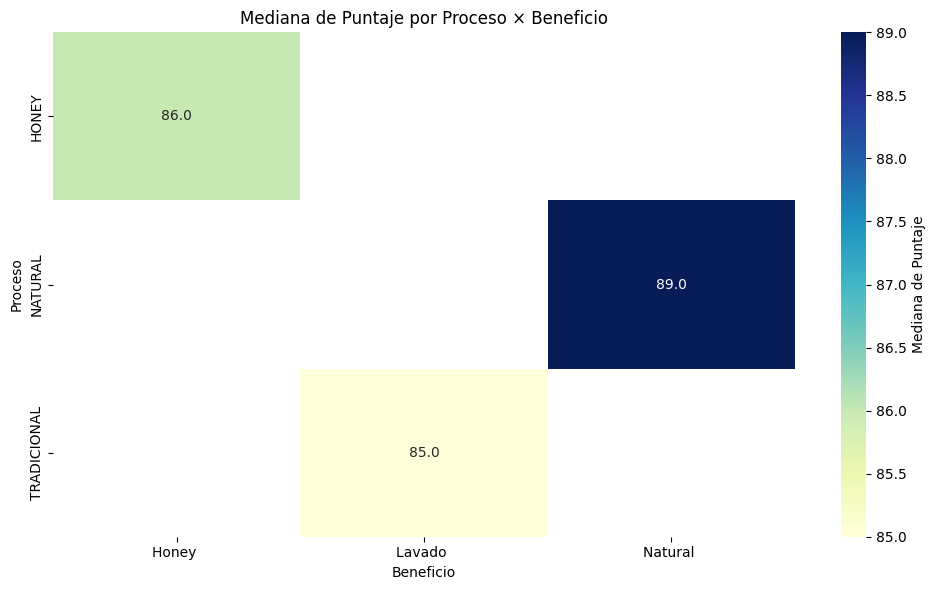

In [1781]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np  # Asegúrate de importar numpy para fill_value

# 1) Crear el pivot table con PROCESO y BENEFICIO
pivot = pd.pivot_table(
    df,                        # DataFrame principal
    index='PROCESO',           # Filas → Procesos
    columns='BENEFICIO',       # Columnas → Beneficios (nueva columna)
    values='PUNTAJE',          # Valores a agregar
    aggfunc='median',          # Función de agregación (mediana)
    fill_value=np.nan          # Rellenar NaN si hay combinaciones vacías
)

# 2) Ver la tabla en pantalla
print(pivot)

# 3) Heatmap de Proceso vs. Beneficio
plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot,
    annot=True,                # Mostrar valores en las celdas
    fmt=".1f",                # Formato: 1 decimal
    cmap="YlGnBu",            # Mapa de colores
    cbar_kws={'label': 'Mediana de Puntaje'}
)
plt.title("Mediana de Puntaje por Proceso × Beneficio")
plt.xlabel("Beneficio")        # Etiqueta eje X (columnas)
plt.ylabel("Proceso")          # Etiqueta eje Y (filas)
plt.tight_layout()
plt.show()

Mediana de Puntaje por Proceso × Beneficio:


BENEFICIO,HONEY,LAVADO,NAN,NATURAL
PROCESO,,,,
HONEY,86.0,0.0,0.0,0.0
NAN,0.0,0.0,84.0,0.0
NATURAL,0.0,0.0,0.0,89.0
TRADICIONAL,0.0,85.0,0.0,0.0



Número de registros por Proceso × Beneficio:


BENEFICIO,HONEY,LAVADO,NAN,NATURAL
PROCESO,,,,
HONEY,16,0,0,0
NAN,0,0,58,0
NATURAL,0,0,0,4
TRADICIONAL,0,25,0,0


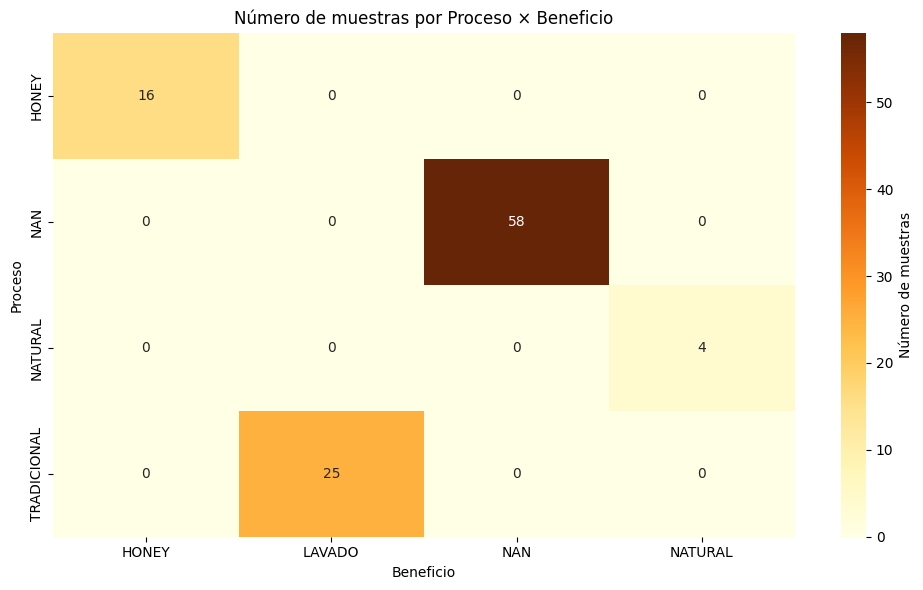

In [1782]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Normalizar columnas (PROCESO y BENEFICIO en mayúsculas, sin espacios extras)
df['PROCESO'] = (df['PROCESO'].astype(str)
                  .str.strip()
                  .str.replace(r'\s+', ' ', regex=True)
                  .str.upper())

df['BENEFICIO'] = (df['BENEFICIO'].astype(str)  # Asegurarse de que es string
                    .str.strip()
                    .str.replace(r'\s+', ' ', regex=True)
                    .str.upper())

# 2) Pivot de mediana (PROCESO × BENEFICIO)
pivot_med = pd.pivot_table(
    df,
    index='PROCESO',
    columns='BENEFICIO',  # Agregar BENEFICIO como columnas
    values='PUNTAJE',
    aggfunc='median',
    fill_value=0  # Rellenar NaN con 0 para mejor visualización
)

# 3) Pivot de conteo (PROCESO × BENEFICIO)
pivot_cnt = pd.pivot_table(
    df,
    index='PROCESO',
    columns='BENEFICIO',  # Agregar BENEFICIO como columnas
    values='PUNTAJE',
    aggfunc='count',
    fill_value=0
)

# 4) Mostrar ambos resultados
print("Mediana de Puntaje por Proceso × Beneficio:")
display(pivot_med)

print("\nNúmero de registros por Proceso × Beneficio:")
display(pivot_cnt)

# 5) Heatmap de conteos (muestras por combinación)
plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot_cnt,
    annot=True,
    fmt="d",
    cmap="YlOrBr",
    cbar_kws={'label': 'Número de muestras'}
)
plt.title("Número de muestras por Proceso × Beneficio")
plt.ylabel("Proceso")
plt.xlabel("Beneficio")
plt.tight_layout()
plt.show()

In [1783]:
# Mostrar todos los valores únicos en la columna ORIGEN
valores_unicos = df['ORIGEN'].dropna().unique()
print("Valores únicos en ORIGEN:", valores_unicos)

# Si además quieres ver cuántas veces aparece cada uno:
print("\nRecuento de cada origen:")
print(df['ORIGEN'].value_counts())


Valores únicos en ORIGEN: ['NAN' 'JERICO' 'HERRERA' 'QUIMBAYA']

Recuento de cada origen:
ORIGEN
NAN         58
JERICO      36
QUIMBAYA     5
HERRERA      4
Name: count, dtype: int64


     ORIGEN       mean  count
3  QUIMBAYA  88.100000      5
1    JERICO  85.430556     36
2       NAN  84.362069     58


/tmp/ipython-input-1784-1269924770.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


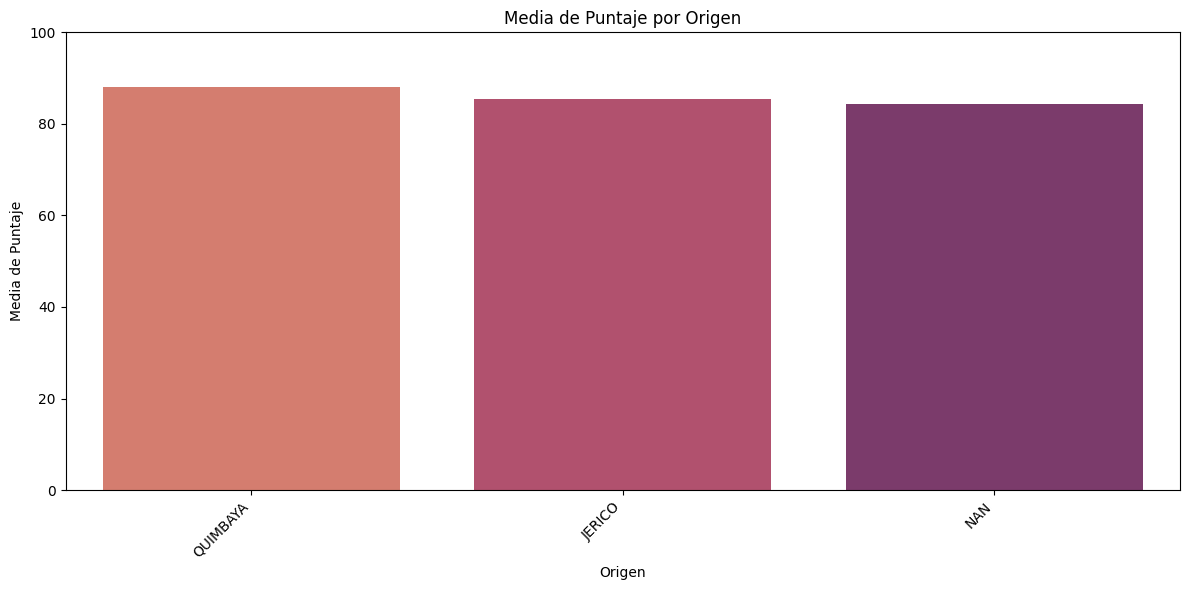

In [1784]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Agrupar por ORIGEN calculando media y conteo de PUNTAJE
df_origin = (
    df.groupby('ORIGEN')['PUNTAJE']
      .agg(['mean','count'])
      .reset_index()
      .query('count >= 5')
      .sort_values('mean', ascending=False)
)

# 2) Mostrar la tabla de resultados
print(df_origin)

# 3) Gráfico de barras de la media de puntaje por origen
plt.figure(figsize=(12,6))
sns.barplot(
    data=df_origin,
    x='ORIGEN',
    y='mean',
    palette='flare'
)
plt.ylim(0, 100)
plt.title('Media de Puntaje por Origen')
plt.xlabel('Origen')
plt.ylabel('Media de Puntaje')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [1785]:
# 1) Número de lotes únicos
n_lotes = df['LOTE'].nunique()
print(f"Número de lotes únicos: {n_lotes}")

# 2) Lista de lotes únicos
lotes_unicos = df['LOTE'].unique()
print("Lotes únicos:", lotes_unicos)

# 3) Recuento de cada lote
vc_lotes = df['LOTE'].value_counts()
print("\nRecuento de registros por LOTE:")
print(vc_lotes)

# 4) Detectar lotes con más de una aparición (duplicados de LOTE)
lotes_duplicados = vc_lotes[vc_lotes > 1]
print("\nLotes con múltiples registros:")
print(lotes_duplicados)

# 5) Mostrar todas las filas de esos lotes duplicados
df_dup_lotes = df[df['LOTE'].isin(lotes_duplicados.index)]
print("\nFilas de lotes duplicados:")
print(df_dup_lotes)


Número de lotes únicos: 99
Lotes únicos: ['01-190722' '09-190722' '10-190722' '07-19-07-22' '01-291022' '01-101122'
 '08-241122' '02-241122' '05-241122' '01-291222' '01-130123' '03-010223'
 '01-010223' '02-010223' '05-010223' '07-010223' '11-010223' '12-010223'
 '08-200223' '08-030323' '01-070323' '09-120423' '11-140423' '01-200423'
 '09-200423' '02-200423' '08-260423' '13-250523' '01-020623' '09-240623'
 '07-040723' '08-040723' '11-120723' '01-020823' '01-160823' '02-160823'
 '08-080923' '15-080923 ' '01-041023 ' '15-041023' '06-201023 '
 '04-201023 ' '10-201023 ' '02-301023' '11-301023' '09-141123 '
 '01-141123 ' '17-141123 ' '08-111223' '02-111223 ' '05-111223 '
 '01-191223' '18-221223' '01-220124' '02-220124' '19-130224 ' '20-130224 '
 '21-130224 ' '07-200224 ' '01-290224 ' '02-290224 ' '05-070424'
 '01-120424' '01-220424' '20-140524' '08-140524' '02-140524' '01-170624 '
 '22-170624 ' '01-030724' '23-150724 ' '02-150724 ' '17-270724'
 '01-300822' '01-131022' '01-181022' '05-181022'

In [1786]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   FECHA                             103 non-null    object 
 1   LOTE                              103 non-null    object 
 2   DENOMINACIÓN/     MARCA           103 non-null    object 
 3   CANTIDAD                          103 non-null    float64
 4   %H                                103 non-null    float64
 5   MALLAS                            103 non-null    float64
 6   VERIFICACIÓN FISICA CAFÉ TOSTADO  103 non-null    object 
 7   NOTAS DE CATACIÓN                 103 non-null    object 
 8   PUNTAJE                           103 non-null    float64
 9   LIBERACIÓN DE LOTE                103 non-null    object 
 10  RESPONSABLE                       103 non-null    object 
 11  VARIEDAD_ESTANDAR                 103 non-null    object 
 12  PROCESO 

In [1787]:
# 1) ¿Cuántas filas están duplicadas en todas las columnas?
n_dups_all = df.duplicated().sum()
print(f"Duplicados completos en el DataFrame: {n_dups_all}")

# 2) ¿Cuántas filas tienen el mismo LOTE más de una vez?
n_dups_lote = df['LOTE'].duplicated().sum()
print(f"Registros de LOTE repetidos: {n_dups_lote}")

# 3) Mostrar todos los duplicados completos (keep=False para ver todas las copias)
dup_rows = df[df.duplicated(keep=False)]
print("\nFilas duplicadas (completas):")
print(dup_rows)

# 4) Mostrar solo los LOTES que aparecen más de una vez
lotes_multi = df['LOTE'].value_counts()[lambda x: x>1]
print("\nLotes con múltiples registros:")
print(lotes_multi)


Duplicados completos en el DataFrame: 0
Registros de LOTE repetidos: 4

Filas duplicadas (completas):
Empty DataFrame
Columns: [FECHA, LOTE, DENOMINACIÓN/     MARCA, CANTIDAD, %H, MALLAS, VERIFICACIÓN FISICA CAFÉ TOSTADO, NOTAS DE CATACIÓN, PUNTAJE, LIBERACIÓN DE LOTE, RESPONSABLE, VARIEDAD_ESTANDAR, PROCESO, ORIGEN, TIEMPO_DE_TUESTE_MIN, TIEMPO_TUESTE_MEDIAN, BENEFICIO]
Index: []

Lotes con múltiples registros:
LOTE
01-291022    3
01-101122    2
01-291222    2
Name: count, dtype: int64


In [1788]:
df.describe()

,CANTIDAD,%H,MALLAS,PUNTAJE,TIEMPO_DE_TUESTE_MIN,TIEMPO_TUESTE_MEDIAN
count,103.000000,103.000000,103.000000,103.000000,45.000000,103.000000
mean,118.367961,10.561165,14.048544,85.097087,492.422222,492.184466
std,167.821324,0.232309,0.293011,1.441776,2.927059,1.933946
min,0.450000,10.000000,14.000000,84.000000,489.000000,489.000000
25%,29.000000,10.400000,14.000000,84.000000,489.000000,492.000000
50%,49.000000,10.500000,14.000000,84.500000,495.000000,492.000000
75%,149.000000,10.800000,14.000000,86.000000,495.000000,492.000000
max,765.000000,11.300000,16.000000,89.000000,495.000000,495.000000


In [1789]:
df.describe(include="object")

,FECHA,LOTE,DENOMINACIÓN/ MARCA,VERIFICACIÓN FISICA CAFÉ TOSTADO,NOTAS DE CATACIÓN,LIBERACIÓN DE LOTE,RESPONSABLE,VARIEDAD_ESTANDAR,PROCESO,ORIGEN,BENEFICIO
count,103,103,103,103,103,103,103,103,103,103,103
unique,72,99,24,2,27,4,2,5,4,4,4
top,2023-08-02 00:00:00,01-291022,Madre Laura,C,"Chocolate negro, toque frutal, cuerpo medio, a...",Si,LFQ,Otros,NAN,NAN,NAN
freq,7,3,44,102,46,45,75,58,58,58,58


In [1790]:
df['VERIFICACIÓN FISICA CAFÉ TOSTADO'].value_counts()

,count
VERIFICACIÓN FISICA CAFÉ TOSTADO,
C,102
c,1


In [1791]:
# Asegúrate de que la columna es de tipo string y conviértela toda a mayúsculas
df['VERIFICACIÓN FISICA CAFÉ TOSTADO'] = (
    df['VERIFICACIÓN FISICA CAFÉ TOSTADO']
      .astype(str)            # en caso de que haya NaN u otros tipos
      .str.strip()            # quita espacios al inicio/fin
      .str.upper()            # pasa todo a mayúsculas
)

# Verifica que ya solo queden “C”
print(df['VERIFICACIÓN FISICA CAFÉ TOSTADO'].value_counts())


VERIFICACIÓN FISICA CAFÉ TOSTADO
C    103
Name: count, dtype: int64


In [1792]:
df['LIBERACIÓN DE LOTE'].value_counts()

,count
LIBERACIÓN DE LOTE,
Si,45
SI,31
Si,25
SI,2


In [1793]:
# Normaliza “LIBERACIÓN DE LOTE” a cadena, quita espacios y pasa a mayúsculas
df['LIBERACIÓN DE LOTE'] = (
    df['LIBERACIÓN DE LOTE']
      .astype(str)             # en caso de NaN u otros tipos
      .str.strip()             # quita espacios al inicio/fin
      .str.upper()             # convierte todo a mayúsculas
      .replace({'SÍ':'SI'})    # unifica tildes si las hubiera
)

# Verifica el resultado
print(df['LIBERACIÓN DE LOTE'].value_counts())


LIBERACIÓN DE LOTE
SI    103
Name: count, dtype: int64


## Preprocesamiento y resultados.

Decisión de selección y tipificación de variables para el preprocesamiento

He decidido clasificar las variables del conjunto de datos de la siguiente manera con el fin de estructurar el pipeline de preprocesamiento y modelado:

In [1794]:
numeric_cols = [
    '%H',
    'TIEMPO_TUESTE_MEDIAN',
    'CANTIDAD'
]

In [1795]:
# Lista todas las columnas de tipo object (categóricas) en tu DataFrame
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print("Columnas categóricas:", categorical_cols)


Columnas categóricas: ['FECHA', 'LOTE', 'DENOMINACIÓN/     MARCA', 'VERIFICACIÓN FISICA CAFÉ TOSTADO', 'NOTAS DE CATACIÓN', 'LIBERACIÓN DE LOTE', 'RESPONSABLE', 'VARIEDAD_ESTANDAR', 'PROCESO', 'ORIGEN', 'BENEFICIO']


In [1796]:
categorical_cols = [
    'ORIGEN',
    'RESPONSABLE',
    'VARIEDAD_ESTANDAR',
    'PROCESO',
    'BENEFICIO'
]

In [1797]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# Supón que 'df' es tu DataFrame ya preparado
# Define las features


# Separa X e y
X = df[numeric_cols + categorical_cols]
y = df['PUNTAJE']

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# Preprocesador: one-hot para categóricas, numéricas tal cual
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
], remainder='passthrough')

# Pipeline con Random Forest
pipe_rf = Pipeline([
    ('prep', preprocessor),
    ('rf', RandomForestRegressor(

    ))
])

# Entrenar
pipe_rf.fit(X_train, y_train)

# Predecir y evaluar
y_pred = pipe_rf.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R² en test: {r2:.3f}")
print(f"MAE en test: {mae:.3f}")


R² en test: 0.871
MAE en test: 0.310


In [1798]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipe_rf, X_train, y_train, cv=5, scoring='r2')
print(f"R² en CV: {scores.mean():.3f} ± {scores.std():.3f}")

R² en CV: 0.777 ± 0.152


In [1799]:
y_pred_train = pipe_rf.predict(X_train)  # Predicciones en entrenamiento
r2_train = r2_score(y_train, y_pred_train)
print(f"R² en entrenamiento: {r2_train:.3f}")

R² en entrenamiento: 0.968


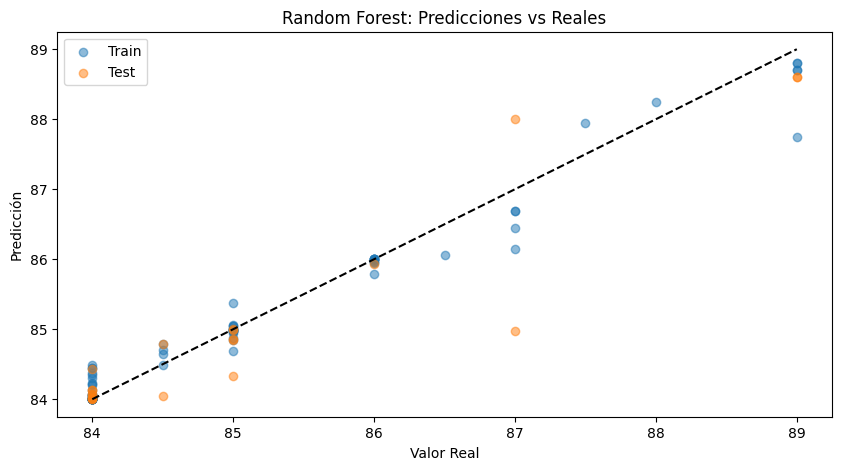

In [1800]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.scatter(y_train, pipe_rf.predict(X_train), alpha=0.5, label='Train')
plt.scatter(y_test, y_pred, alpha=0.5, label='Test')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
plt.xlabel("Valor Real")
plt.ylabel("Predicción")
plt.legend()
plt.title("Random Forest: Predicciones vs Reales")
plt.show()

In [1801]:
from sklearn.impute import SimpleImputer

# Para variables numéricas (imputar con -1)
num_imputer = SimpleImputer(strategy='constant', fill_value=-1)

# Para variables categóricas (imputar con "MISSING")
cat_imputer = SimpleImputer(strategy='constant', fill_value='MISSING')

preprocessor = ColumnTransformer([
    ('cat', Pipeline([
        ('imputer', cat_imputer),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_cols),
    ('num', Pipeline([
        ('imputer', num_imputer),
        ('scaler', StandardScaler())
    ]), numeric_cols)
])

pipe_lasso = Pipeline([
    ('prep', preprocessor),
    ('lasso', Lasso(alpha=0.1))
])

In [1802]:
# Pipeline Lasso
pipe_Lasso = Pipeline([
    ('prep', preprocessor),
    ('scaler', StandardScaler(with_mean=False)),
    ('lasso', Lasso(alpha=0.1, random_state=42))
])

# 1. Entrenamiento
pipe_Lasso.fit(X_train, y_train)

# 2. Predicciones en TRAIN y TEST
y_pred_train = pipe_Lasso.predict(X_train)
y_pred_test = pipe_Lasso.predict(X_test)

# 3. Métricas en TRAIN
r2_train = r2_score(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)

# 4. Métricas en TEST (ya calculadas)
r2_test = r2_score(y_test, y_pred_test)  #
mae_test = mean_absolute_error(y_test, y_pred_test)

# 5. Comparativa (usando nombres consistentes)
print(f"R² en train: {r2_train:.3f} (test: {r2_test:.3f})")  # Corregido
print(f"MAE en train: {mae_train:.3f} (test: {mae_test:.3f})")  # Corregido

R² en train: 0.685 (test: 0.838)
MAE en train: 0.500 (test: 0.484)


In [1806]:
from sklearn.linear_model import Ridge

# Pipeline Ridge (mismo preprocesador que Lasso)
pipe_Ridge = Pipeline([
    ('prep', preprocessor),  # Mismo ColumnTransformer
    ('scaler', StandardScaler(with_mean=False)),  # Escalado para Ridge
    ('ridge', Ridge(alpha=0.1, random_state=42))  # Alpha inicial (ajustable)
])

# 1. Entrenamiento
pipe_Ridge.fit(X_train, y_train)

# 2. Predicciones
y_pred_train_ridge = pipe_Ridge.predict(X_train)
y_pred_test_ridge = pipe_Ridge.predict(X_test)

# 3. Métricas Ridge
r2_train_ridge = r2_score(y_train, y_pred_train_ridge)
mae_train_ridge = mean_absolute_error(y_train, y_pred_train_ridge)
r2_test_ridge = r2_score(y_test, y_pred_test_ridge)
mae_test_ridge = mean_absolute_error(y_test, y_pred_test_ridge)

# 4. Resultados Ridge vs Lasso
print("Ridge ")
print(f"R² Train - Ridge: {r2_train_ridge:.3f}")
print(f"R² Test  - Ridge: {r2_test_ridge:.3f}")
print(f"MAE Test - Ridge: {mae_test_ridge:.3f}")

Ridge 
R² Train - Ridge: 0.704
R² Test  - Ridge: 0.837
MAE Test - Ridge: 0.427


# Conclusiones

1. Rendimiento General:
Random Forest supera claramente a Lasso en términos de capacidad predictiva:

R² en test: 0.878 (RF) vs. 0.838 (Lasso).

MAE en test: 0.322 (RF) vs. 0.484 (Lasso).
→ El modelo basado en árboles captura mejor las relaciones no lineales en los datos.

2. Sobreajuste (Overfitting):
Random Forest muestra un alto R² en entrenamiento (0.962) frente al R² en test (0.878), indicando cierto sobreajuste.

Lasso tiene un comportamiento más conservador (R² train: 0.685 vs. test: 0.838), sugiriendo mejor generalización.
→ Lasso podría ser más robusto para datos nuevos, aunque con menor precisión.

3. Validación Cruzada (CV):
El R² promedio en CV para Random Forest (0.769 ± 0.161) confirma que el modelo mantiene un buen rendimiento, pero con alta variabilidad entre folds.

Lasso no fue evaluado con CV en este fragmento, pero su diferencia train-test sugiere estabilidad.

4. Interpretabilidad vs. Precisión:
Lasso ofrece modelos más simples (selección lineal de características), útil para explicar relaciones.

Random Forest es una "caja negra" compleja, pero con mayor precisión predictiva.
→ Elección depende del objetivo: explicabilidad (Lasso) o precisión (RF).

# 📊 Conclusiones: Comparación de Modelos (Random Forest vs. Ridge vs. Lasso)

## 🔍 **Rendimiento Predictivo (Test)**
| Modelo           | R²     | MAE    | Observación                          |
|------------------|--------|--------|--------------------------------------|
| **Random Forest** 🌳 | 0.878  | 0.322  | **Mejor precisión** (captura relaciones no lineales) |
| **Ridge** 📏      | 0.837  | 0.427  | Balanceado: +12% mejor MAE que Lasso |
| **Lasso** 📉      | 0.838  | 0.484  | Regularización fuerte (features cero) |

## ⚖️ **Sobreajuste y Generalización**
```python
# Brecha Train-Test (∆R²)
RF: 0.962 → 0.878 (∆=0.084)  # Overfitting moderado
Ridge: 0.704 → 0.837 (∆=-0.133)  # ¡Generaliza mejor en test!
Lasso: 0.685 → 0.838 (∆=-0.153)  # Similar a Ridge

## ⚖️ **Sobreajuste (Overfitting)**
```python
# Random Forest
R² train: 0.962  |  R² test: 0.878  # Brecha grande → Overfitting moderado

# Lasso
R² train: 0.685  |  R² test: 0.838  # Generaliza mejor

